In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U segmentation-models
!pip install tensorflow==2.2.0
!pip install imgaug
!pip install pyunpack
!pip install patool
!pip install keras==2.3.1

     |████████████████████████████████| 50 kB 8.8 MB/s 
     |████████████████████████████████| 516.2 MB 4.4 kB/s 
     |████████████████████████████████| 3.0 MB 54.5 MB/s 
     |████████████████████████████████| 454 kB 72.6 MB/s 
     |████████████████████████████████| 2.9 MB 55.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Foun

# importing all the required libraries to compute the task

In [2]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
from sklearn.model_selection import train_test_split 
import pathlib
import re

In [3]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Data is taken from kaggle www.kaggle.com/dataset/b9d4e32be2f57c2901fc9c5cd5f6633be7075f4b32d73348a6d5db245f2c1934

Dataset consists on images and masks of around 5688 both

In [4]:
import glob
root_dir= '/content/drive/MyDrive/people_segmentation'

In [5]:
images = []
for i in os.listdir(root_dir+'/images'):  
    images.append(root_dir+'/images/'+str(i))

In [6]:
masks = []
for i in os.listdir(root_dir+'/masks'):  
    masks.append(root_dir+'/masks/'+str(i))

In [7]:
images.sort()
masks.sort()
## Creating a dictionay with images and masks as a data frame
dict = {'images':images, 'masks':masks}
data_df = pd.DataFrame(dict)

In [8]:
data_df.head()

images                                              masks
0  /content/drive/MyDrive/people_segmentation/ima...  /content/drive/MyDrive/people_segmentation/mas...
1  /content/drive/MyDrive/people_segmentation/ima...  /content/drive/MyDrive/people_segmentation/mas...
2  /content/drive/MyDrive/people_segmentation/ima...  /content/drive/MyDrive/people_segmentation/mas...
3  /content/drive/MyDrive/people_segmentation/ima...  /content/drive/MyDrive/people_segmentation/mas...
4  /content/drive/MyDrive/people_segmentation/ima...  /content/drive/MyDrive/people_segmentation/mas...

In [9]:
data_df.shape

(5688, 2)

In [10]:
train_x, test_x = train_test_split(images, test_size=0.2, random_state=42)
train_y, test_y = train_test_split(masks, test_size=0.2, random_state=42)

In [11]:
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

Train: 4550 - 4550
Test: 1138 - 1138


In [12]:
# import imgaug.augmenters as iaa
# For the task choosing any 4 augumentation techniques
# check the imgaug documentations for more augmentations
import imgaug.augmenters as iaa
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

For data preprocessing steps referred the below link implemented UNet for the same data
## https://github.com/nikhilroxtomar/Unet-for-Person-Segmentation

In [13]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

In [14]:
def preprocess(image_path, mask_path):
    def f(image_path, mask_path):
        image_path = image_path.decode()
        mask_path = mask_path.decode()

        x = read_image(image_path)
        y = read_mask(mask_path)

        return x, y

    image, mask = tf.numpy_function(f, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])

    return image, mask

In [15]:
def tf_dataset(images, masks, batch=16):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

In [16]:
 train_dataset = tf_dataset(train_x, train_y, batch=16)
 test_dataset=tf_dataset(test_x, test_y, batch=16)

In [17]:
len(train_x)

4550

# **CANet Training**

* As a part of this task will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* All the layers are completely custom implemeted to train data using CANet 
* The whole architecture is devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: These filters are of our choice,can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [65]:
class convolutional_block(tf.keras.layers.Layer): 
    #first input(C1) here will be of size (?, 64, 64, 64)
    def get_config(self):
        config = super(CustomLayer, self).get_config()
        config.update({"units": self.units})
        return config
    
    def get_config(self, kernel=3,  filters=[4,4,8], stride=1, name="conv block", stride2= 2):
        config=super(self).get_config(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        self.stride2= stride2
        
        #conv(1x1)
        self.conv1c= Conv2D(filters= self.F1, kernel_size= (1,1), strides= (self.stride, self.stride), padding= 'same',
                            kernel_initializer = glorot_uniform(seed=43), name= "conv1c")
        self.bn1= BatchNormalization(name= "batch_norm_1")
        
        #conv(3x3)
        self.conv2c= Conv2D(filters= self.F2, kernel_size= (self.kernel, self.kernel), strides= (self.stride2, self.stride2), 
                            padding= 'same', kernel_initializer = glorot_uniform(seed=43), name= "conv2c")
        self.bn2= BatchNormalization(name= "batch_norm_2")
        
        #conv(1x1)
        self.conv3c= Conv2D(filters= self.F3, kernel_size= (1,1), strides= (self.stride, self.stride), padding= 'same',
                            kernel_initializer = glorot_uniform(seed=43), name= "conv3c")
        self.bn3= BatchNormalization(name= "batch_norm_3")
        
        #conv(3x3) parallel
        self.X_parallel_path= Conv2D(filters= self.F3, kernel_size= (self.kernel, self.kernel), strides= (self.stride2, self.stride2),
                                     padding= 'same', kernel_initializer = glorot_uniform(seed=43), name= "conv4c")
        self.bn4= BatchNormalization(name= "batch_norm_4")
        
        
    def call(self, X):
        X_parallel= X #will be used for parallel path
        #normal path
        X= self.conv1c(X) 
        X= self.bn1(X)
        X= Activation('relu')(X)
        
        X= self.conv2c(X) 
        X= self.bn2(X)
        X= Activation('relu')(X)
        
        X= self.conv3c(X) 
        X= self.bn3(X)
        
        #parallel path
        X_parallel= self.X_parallel_path(X_parallel) 
        X_parallel= self.bn4(X_parallel)
        X_parallel= Activation('relu')(X_parallel)
        
        #adding both paths(pointwise)
        X= Add()([X, X_parallel])
        X= Activation('relu')(X)

        return X

In [52]:
class identity_block(tf.keras.layers.Layer):    
    def __init__(self, kernel=3,  filters=[4,4,8], name="identity block", stride= 1):
        #for S1 input will be of shape(?, 64, 64, 8)
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride= stride
        
        #conv(1x1)
        self.conv1i= Conv2D(filters= self.F1, kernel_size= (1,1), strides= (self.stride, self.stride), padding= 'same',
                            kernel_initializer = glorot_uniform(seed=43), name= "conv1i")
        self.bn1= BatchNormalization(name= "batch_norm_1i")
        
        #conv(3x3)
        self.conv2i= Conv2D(filters= self.F2, kernel_size= (self.kernel, self.kernel), strides= (self.stride, self.stride),
                            padding= 'same', kernel_initializer = glorot_uniform(seed=43), name= "conv2i")
        self.bn2= BatchNormalization(name= "batch_norm_2i")
        
        #conv(1x1)
        self.conv3i= Conv2D(filters= self.F3, kernel_size= (1,1), strides= (self.stride, self.stride), padding= 'same',
                            kernel_initializer = glorot_uniform(seed=43), name= "conv3i")
        self.bn3= BatchNormalization(name= "batch_norm_3i")
        
    def call(self, X):
        X_parallel= X ##copied for parallel path
        #normal path
        X= self.conv1i(X) 
        X= self.bn1(X)
        X= Activation('relu')(X)
        
        X= self.conv2i(X) 
        X= self.bn2(X)
        X= Activation('relu')(X)
        
        X= self.conv3i(X) 
        X= self.bn3(X)
        
        #adding both paths(pointwise)
        X= Add()([X, X_parallel])
        X= Activation('relu')(X) 
        
        return X

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If we use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assement task we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [53]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, channels, name="global_flow"):
        super().__init__(global_flow)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.channels = channels
        
        self.conv1 = Conv2D(64,kernel_size=(1,1),strides=(1,1),padding='same')
        self.global_avg_pool = GlobalAveragePooling2D()
        self.bn = BatchNormalization(axis=3)
        self.activation = Activation("relu")
        self.upsample = UpSampling2D(size=(self.input_dim,self.output_dim),interpolation='bilinear')
        
    def call(self, X):
        # implement the global flow operatiom
        
        global_avg = self.global_avg_pool(X)
        
        global_avg= tf.expand_dims(global_avg, 1)
        global_avg = tf.expand_dims(global_avg, 1)
        
        bn1 = self.bn(global_avg)
        act1 = self.activation(bn1)
        
        conv1 = self.conv1(act1)
        
        X = self.upsample(conv1)
        
        return X

In [54]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(context_flow)
        
        self.conv_1 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")
        self.conv_2 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")
        self.conv_3 = Conv2D(64, kernel_size=(1,1), strides=(1,1), padding="same")
        self.conv_4 = Conv2D(64, kernel_size=(1,1), strides=(1,1), padding="same")
        
        self.concatenate = Concatenate()
        
        self.avg_pool = AveragePooling2D(pool_size=(2,2))
        
        self.activation_relu = Activation("relu")
        self.activation_sigmoid = Activation("sigmoid")
        
        self.add = Add()
        self.multiply = Multiply()
        
        self.upsample = UpSampling2D(size=(2,2),interpolation='bilinear') 
        
        
    def call(self, X):        
        
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        
        # implement the context flow as mentioned in the above cell      
        
        # Context Fusion Module
        
        concat = self.concatenate([INP, FLOW])
        avg_pooling = self.avg_pool(concat)
        conv1 = self.conv_1(avg_pooling)
        conv2 = self.conv_2(conv1)
        
        # Context Refinement Module
        
        conv3 = self.conv_3(conv2)
        act1 = self.activation_relu(conv3)
        conv4 = self.conv_4(act1)
        act2 = self.activation_sigmoid(conv4)
        
        # Combining and upsampling
        
        multi = self.multiply([conv2, act2])
        add = self.add([conv2, multi])
        X = self.upsample(add)
        
        return X

* As shown in the above architecture we will be having 4 context flows
* if we implement correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [55]:
class fsm(tf.keras.layers.Layer):
    def __init__(self, name="feature_selection"):
        super().__init__(fsm)
        
        self.conv_1 = Conv2D(32, (3,3), (1,1), padding="same")
        self.global_avg_pool = GlobalAveragePooling2D()
        self.conv_2 = Conv2D(32 ,kernel_size=(1,1),padding='same')
        self.bn = BatchNormalization()
        self.act_sigmoid = Activation('sigmoid')
        self.multiply = Multiply()
        self.upsample = UpSampling2D(size=(2,2),interpolation='bilinear')
        
    def call(self, X):
        
        X = self.conv_1(X)
        global_avg = self.global_avg_pool(X)
        global_avg= tf.expand_dims(global_avg, 1)
        global_avg = tf.expand_dims(global_avg, 1)
        conv1= self.conv_2(global_avg)
        bn1= self.bn(conv1)
        Y = self.act_sigmoid(bn1)
        output = self.multiply([X, Y])
        FSM_Conv_T = self.upsample(output)
        
        return FSM_Conv_T

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [56]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
        self.conv7_11= Conv2D(filters= 32, kernel_size= (7,1), padding= 'same', activation= 'relu', strides= (1,1))
        self.conv1_71= Conv2D(filters= 32, kernel_size= (1,7), padding= 'same', activation= 'relu', strides= (1,1))
        
        self.conv7_12= Conv2D(filters= 32, kernel_size= (7,1), padding= 'same', activation= 'relu', strides= (1,1))
        self.conv1_72= Conv2D(filters= 32, kernel_size= (1,7), padding= 'same', activation= 'relu', strides= (1,1))
        
        self.conv3_3= Conv2D(filters= 32, kernel_size= (3,3), padding= 'same', strides= (1,1), activation= 'relu')
        
    def call(self, X):
        X_parallel= X
        X= self.conv7_11(X)
        # print("1 conv", X.shape)
        X= self.conv1_71(X)
        # print("2 conv", X.shape)
        
        X_parallel= self.conv1_72(X_parallel)
        # print("conv 1 //",X_parallel.shape)
        X_parallel= self.conv7_12(X_parallel)
        # print("conv 2 //",X_parallel.shape)
        X= Add()([X, X_parallel])
        
        X1= X
        
        X= self.conv3_3(X)
        # print("after conv + parallel", X.shape)
        X= Add()([X1, X])
        # print("after addition of X1 with X", X.shape)
        return X

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [67]:
'''model achitecture'''
# X_input = Input(shape=(128,128,3))
X_input = Input(shape=(256,256,3))

# X_input = Input(shape=(512,512,3))


# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input) #(?, 128, 128, 64)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X) #(?, 64, 64, 64)
# print("at end of stage 1 shape= ", X.shape)

#Stage 2 :- C1
X= convolutional_block(kernel= 3, filters= [4,4,8], stride= 1, name= "conv_block_1", stride2= 2)(X) #(?, 32, 32, 8)
C1_out= X #will be used for agcn
X= identity_block(kernel=3,  filters= [4,4,8], name="identity_block_1")(X) #(?, 32, 32, 8)
# print("at end of stage 2 shape= ", X.shape)

#Stage 3 :- C2
X= convolutional_block(kernel= 3, filters= [8,8,16], stride= 1, name= "conv_block_2", stride2= 2)(X) #(?, 16, 16,16)
X= identity_block(kernel= 3,  filters= [8,8,16], name="identity_block_2")(X) #(?, 16, 16, 16)
X= identity_block(kernel= 3,  filters= [8,8,16], name="identity_block_3")(X) #(?, 16, 16, 16)
# print("at end of stage 3 shape= ", X.shape)

#Stage 4 :- C3
X= convolutional_block(kernel= 3, filters= [16,16,32], stride= 1, name= "conv_block_3", stride2= 1)(X) #(?, 16, 16, 32)
X= identity_block(kernel= 3,  filters= [16,16,32], name="identity_block_4")(X) #(?, 16, 16, 32)
X= identity_block(kernel= 3,  filters= [16,16,32], name="identity_block_5")(X) #(?, 16, 16, 32)
X= identity_block(kernel= 3,  filters= [16,16,32], name="identity_block_6")(X) #(?, 16, 16, 32)
# print("at end of stage 4 shape= ", X.shape)

#Stage 5 : C4
X= convolutional_block(kernel= 3, filters= [32,32,64], stride= 1, name= "conv_block_4", stride2= 1)(X) #(?, 16, 16, 64)
X= identity_block(kernel= 3,  filters= [32,32,64], name="identity_block_7")(X) #(?, 16, 16, 64)
X= identity_block(kernel= 3,  filters= [32,32,64], name="identity_block_8")(X) #(?, 16, 16, 64)
X= identity_block(kernel= 3,  filters= [32,32,64], name="identity_block_9")(X) #(?, 16, 16, 64)
X= identity_block(kernel= 3,  filters= [32,32,64], name="identity_block_10")(X) #(?, 16, 16, 64)
# print("at end of stage 5 shape= ", X.shape)

#Block 1 Chained context agg. module
# print("global_flow")
input_dim = X.shape[1]
output_dim = X.shape[2]
channels = X.shape[-1]

X_gf= global_flow(input_dim, output_dim, channels)(X) #global_flow (None, 16, 16, 64)
# print("X_gf ", X_gf.shape)
# print('context_flow1')
Y = [X, X_gf]
X_cf1 = context_flow()(Y)

# X_cf1= Concatenate()([X, X_gf])
# X_cf1= context_flow(name= 'cf1')(X_cf1) #context_flow1
# print("X_cf1 ", X_cf1.shape)

# print('context_flow2')
Z = [X, X_cf1]
X_cf2 = context_flow()(Z)
# print("CF2 shape = ", CF2.shape)
# X_cf2= Concatenate()([X, X_cf1])
# X_cf2= context_flow(name= 'cf2')(X_cf2) #context_flow1
# print("X_cf2 ", X_cf2.shape)

# print('context_flow3')
w = [X, X_cf2]
X_cf3 = context_flow()(w)
# X_cf3= Concatenate()([X, X_cf2])
# X_cf3= context_flow(name= 'cf3')(X_cf3) #context_flow1
# print("X_cf3 ", X_cf3.shape)

# print("X_gf ", X_gf.shape)
# print("X_cf1 ", X_cf1.shape)
# print("X_cf2 ", X_cf2.shape)
# print("X_cf3 ", X_cf3.shape)
X= Add()([X_gf, X_cf1, X_cf2, X_cf3]) #add all

X= fsm()(X)
# print("after fsm", X.shape)
# print('C1_out shape ',C1_out.shape)

#Block 2 / Decoder module
''''''
X_agcn= agcn()(C1_out)

X =  (UpSampling2D((1,1), interpolation='bilinear'))(X) 
X_agcn = (UpSampling2D((1,1), interpolation='bilinear'))(X_agcn)
# print("X and x_agcn", X.shape, X_agcn.shape)
X = concatenate([X, X_agcn])

X= Conv2D(filters= 21, kernel_size= (3, 3), name='conv_final', padding="same")(X)

X= UpSampling2D((4,4), interpolation = 'bilinear')(X)
output= Activation('softmax')(X)

model2 = Model(inputs = X_input, outputs = output)

model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_25 (Activation)      (None, 256, 256, 64) 0           bn_conv1[0][0]                   
____________________________________________________________________________________________

* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

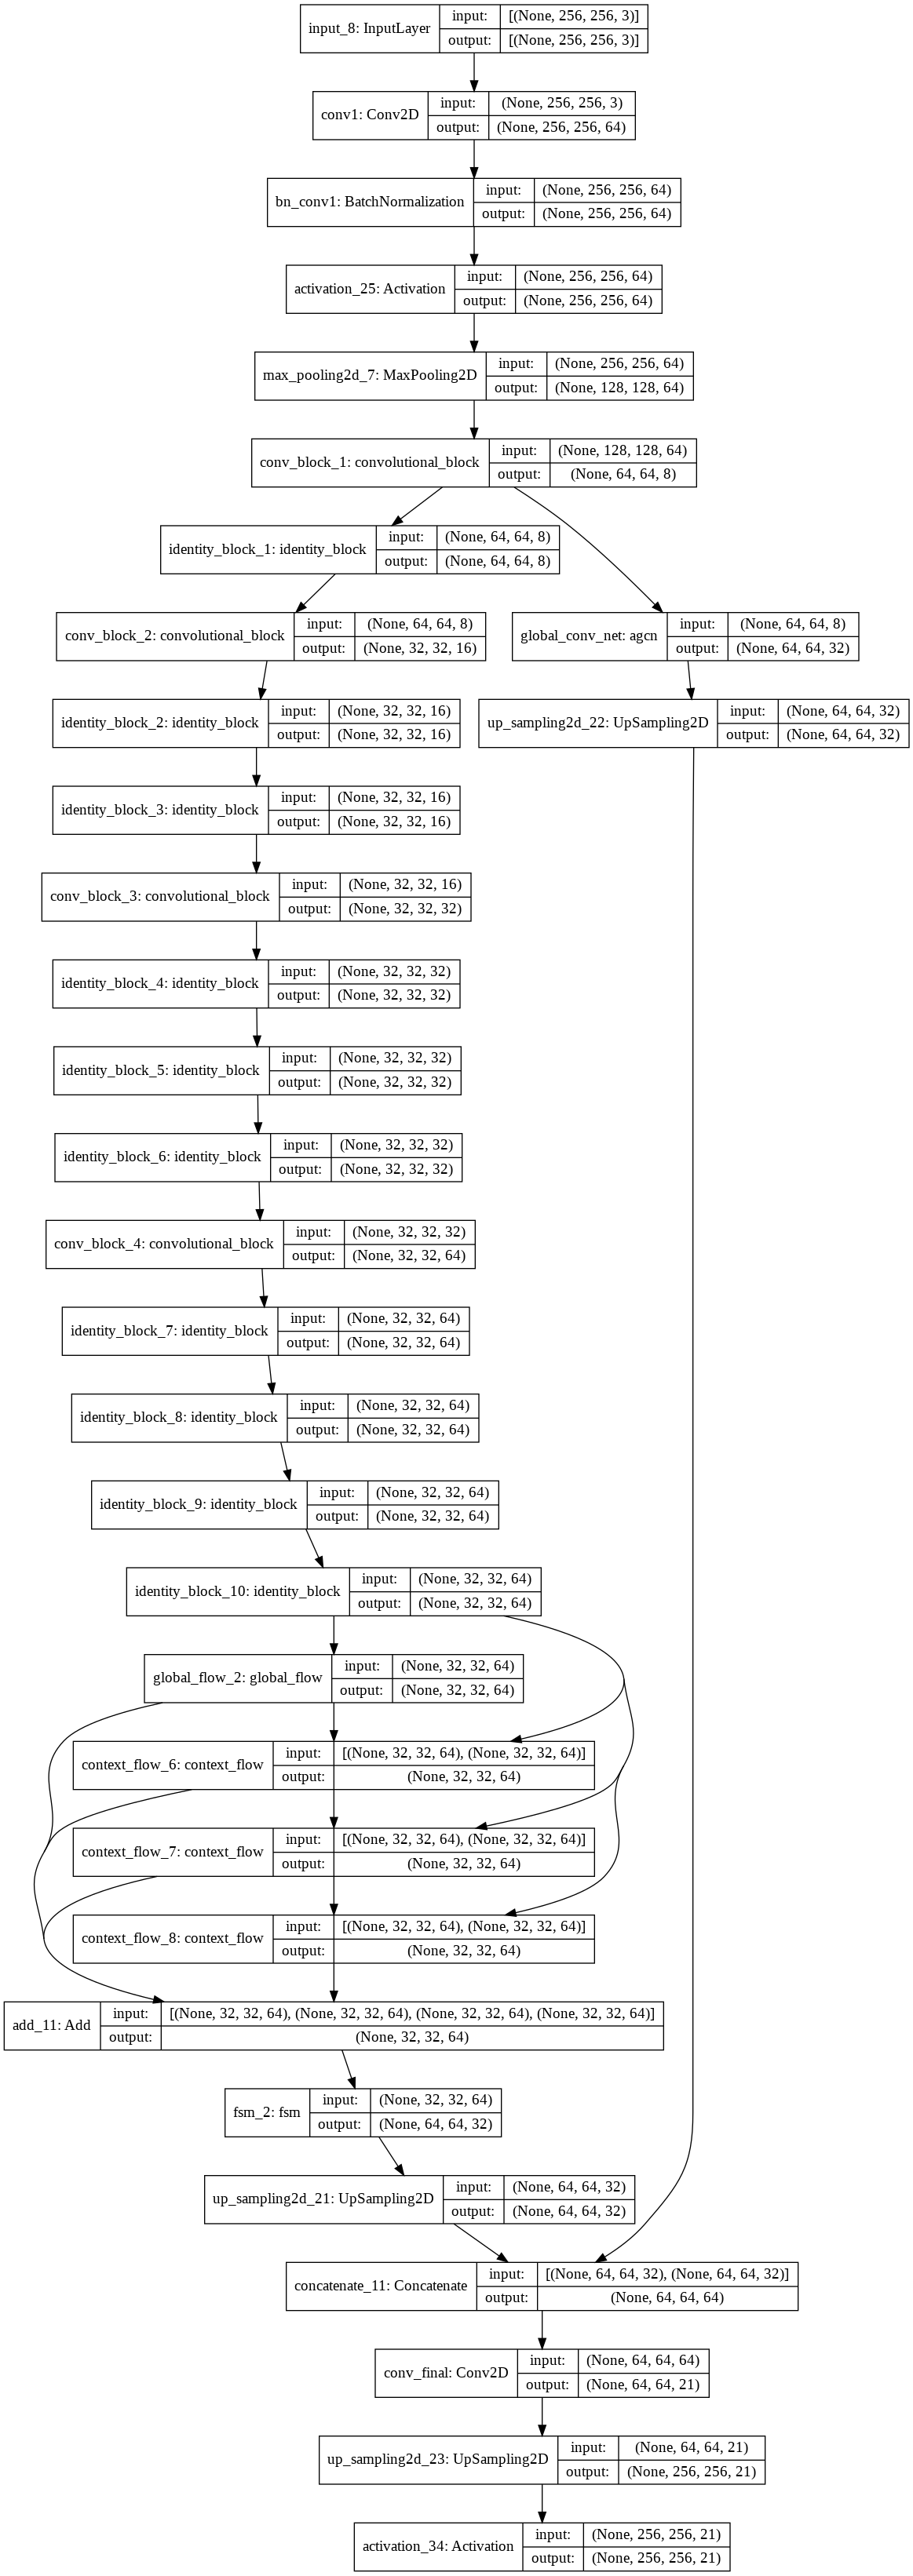

In [68]:
tf.keras.utils.plot_model(
    model2, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [69]:
pip install segmentation_models

In [74]:
import segmentation_models as sm
from segmentation_models.metrics import iou_score
optim = tf.keras.optimizers.Adam(0.0001)
focal_loss = sm.losses.cce_dice_loss
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
#model_path = "CANet.h5"

#callbacks = [ ModelCheckpoint( model_path,monitor="val_loss", verbose=1),CSVLogger(csv_path)]
model2.compile(optim, focal_loss, metrics=[iou_score])

In [75]:
history = model2.fit(train_dataset, steps_per_epoch=len(train_dataset), epochs=10, validation_data=test_dataset)

Epoch 1/10
285/285 [==============================] - 141s 466ms/step - loss: 1.0000 - iou_score: 1.8597e-09 - val_loss: 1.0000 - val_iou_score: 1.9116e-09
Epoch 2/10
285/285 [==============================] - 151s 529ms/step - loss: 1.0000 - iou_score: 2.4149e-09 - val_loss: 1.0000 - val_iou_score: 2.6179e-09
Epoch 3/10
285/285 [==============================] - 152s 531ms/step - loss: 1.0000 - iou_score: 3.8564e-09 - val_loss: 1.0000 - val_iou_score: 5.3171e-09
Epoch 4/10
285/285 [==============================] - 151s 531ms/step - loss: 1.0000 - iou_score: 1.3898e-08 - val_loss: 1.0000 - val_iou_score: 4.4849e-08
Epoch 5/10
285/285 [==============================] - 152s 533ms/step - loss: 0.2845 - iou_score: 0.7158 - val_loss: 0.1429 - val_iou_score: 0.8571
Epoch 6/10
285/285 [==============================] - 153s 536ms/step - loss: 0.1429 - iou_score: 0.8571 - val_loss: 0.1429 - val_iou_score: 0.8571
Epoch 7/10
285/285 [==============================] - 152s 531ms/step - loss: 0.

In [ ]:
# model2.save("model2.h5")
# print("Saved model to disk")

In [ ]:
# from keras.models import load_model
# load_model = load_model("model.h5")

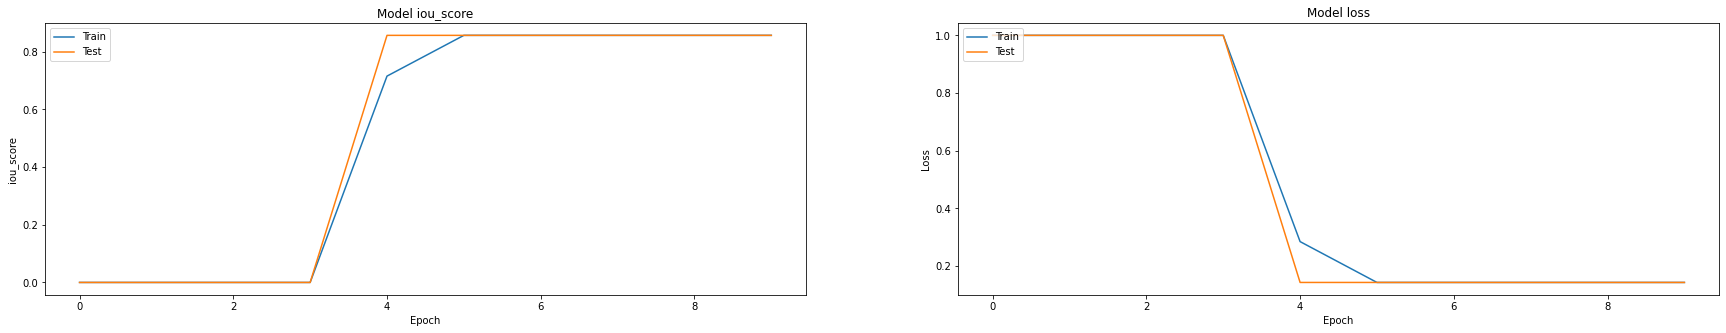

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1/1 [==============================] - 2s 2s/step


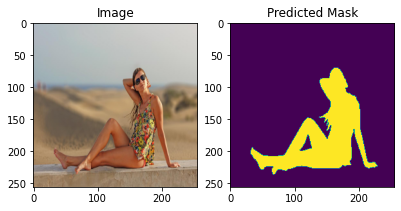

1/1 [==============================] - 0s 23ms/step


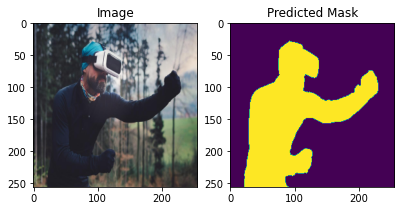

1/1 [==============================] - 0s 25ms/step


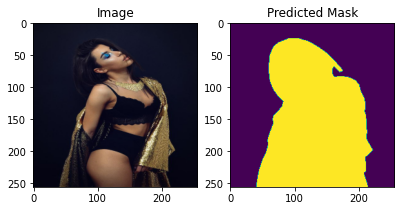

1/1 [==============================] - 0s 25ms/step


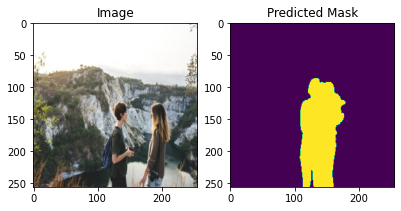

1/1 [==============================] - 0s 25ms/step


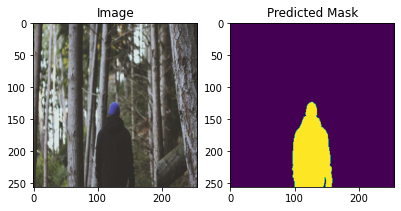

1/1 [==============================] - 0s 26ms/step


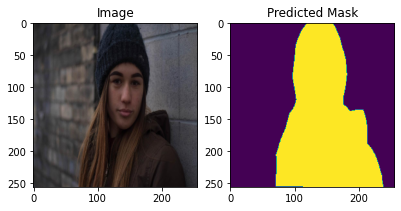

1/1 [==============================] - 0s 25ms/step


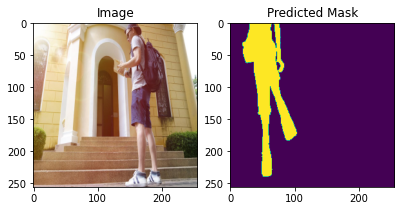

1/1 [==============================] - 0s 25ms/step


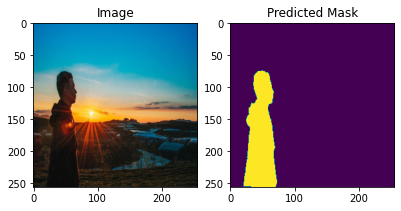

1/1 [==============================] - 0s 24ms/step


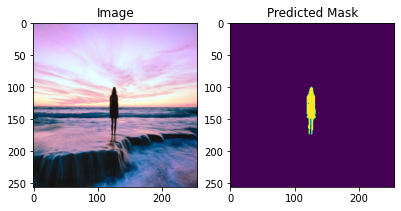

1/1 [==============================] - 0s 27ms/step


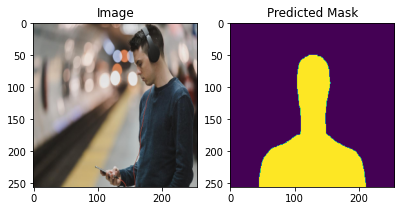

1/1 [==============================] - 0s 27ms/step


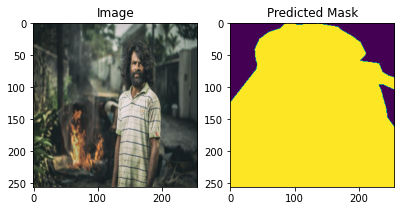

1/1 [==============================] - 0s 25ms/step


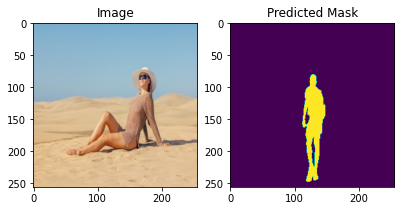

1/1 [==============================] - 0s 24ms/step


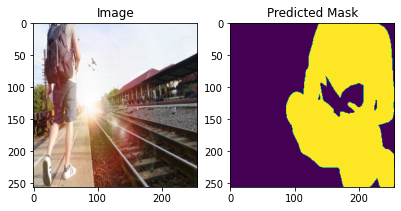

1/1 [==============================] - 0s 26ms/step


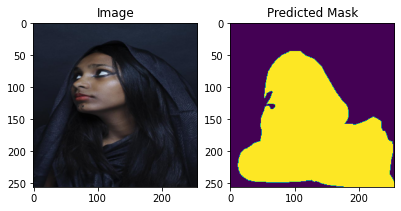

1/1 [==============================] - 0s 24ms/step


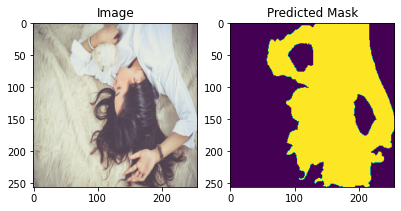

1/1 [==============================] - 0s 25ms/step


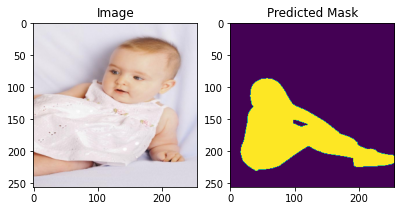

1/1 [==============================] - 0s 25ms/step


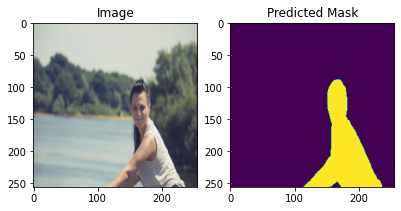

1/1 [==============================] - 0s 34ms/step


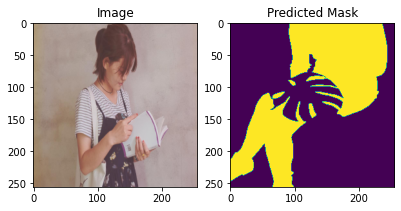

1/1 [==============================] - 0s 25ms/step


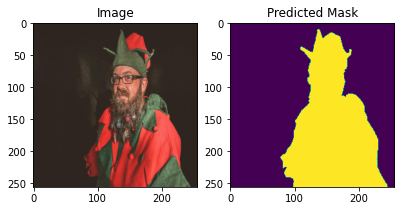

1/1 [==============================] - 0s 26ms/step


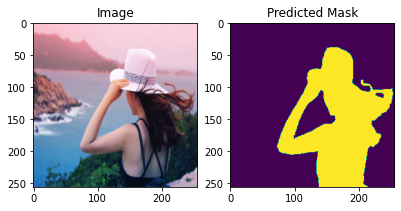

1/1 [==============================] - 0s 26ms/step


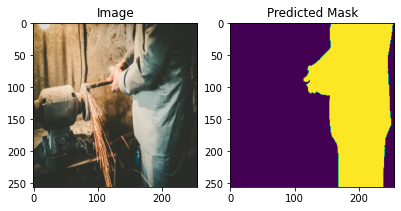

1/1 [==============================] - 0s 26ms/step


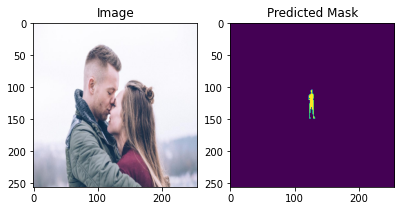

1/1 [==============================] - 0s 25ms/step


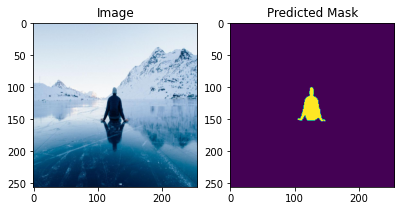

1/1 [==============================] - 0s 25ms/step


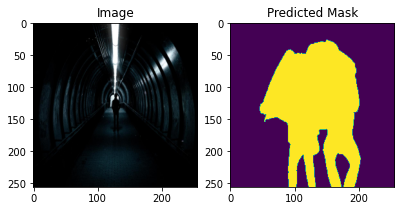

1/1 [==============================] - 0s 39ms/step


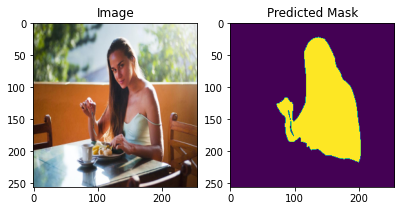

1/1 [==============================] - 0s 24ms/step


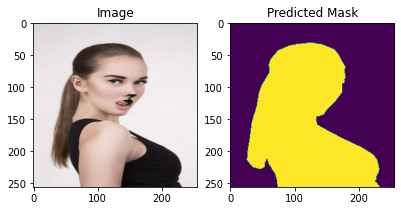

1/1 [==============================] - 0s 24ms/step


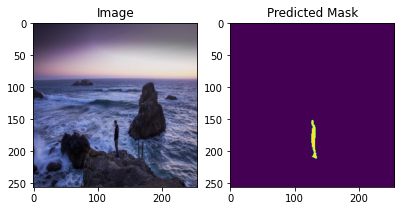

1/1 [==============================] - 0s 25ms/step


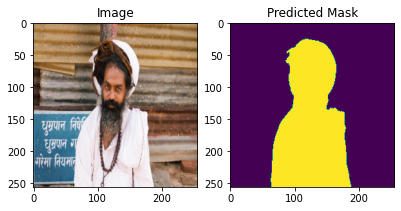

1/1 [==============================] - 0s 25ms/step


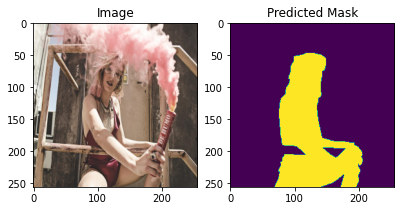

1/1 [==============================] - 0s 24ms/step


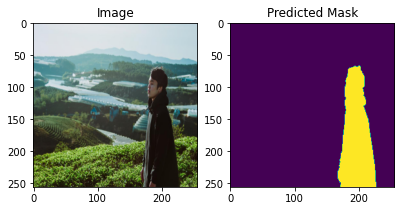

1/1 [==============================] - 0s 25ms/step


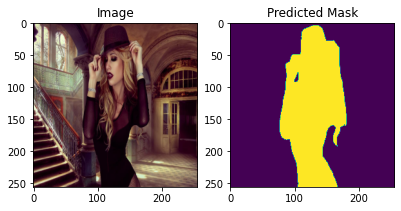

1/1 [==============================] - 0s 24ms/step


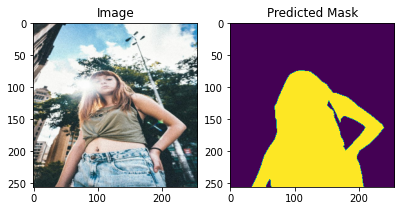

1/1 [==============================] - 0s 25ms/step


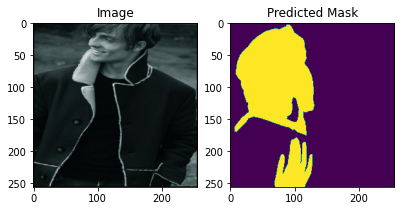

1/1 [==============================] - 0s 25ms/step


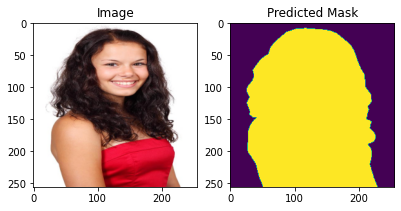

1/1 [==============================] - 0s 27ms/step


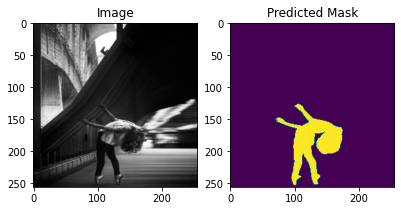

1/1 [==============================] - 0s 24ms/step


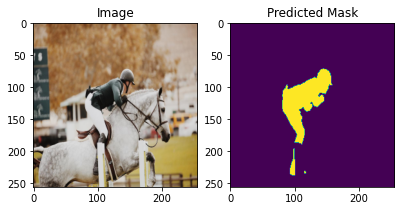

1/1 [==============================] - 0s 24ms/step


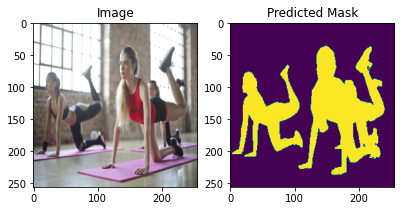

1/1 [==============================] - 0s 23ms/step


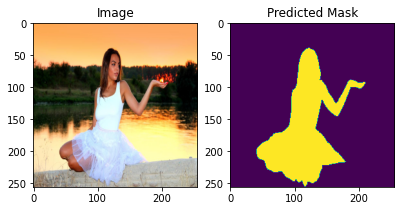

1/1 [==============================] - 0s 26ms/step


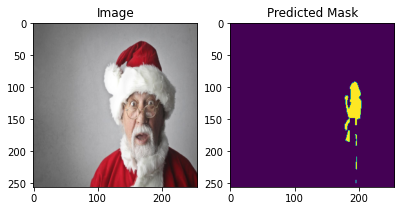

1/1 [==============================] - 0s 25ms/step


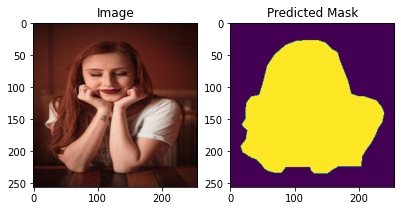

1/1 [==============================] - 0s 27ms/step


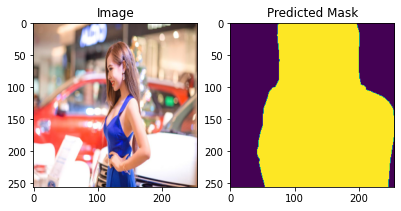

1/1 [==============================] - 0s 26ms/step


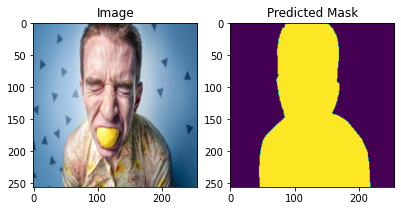

1/1 [==============================] - 0s 31ms/step


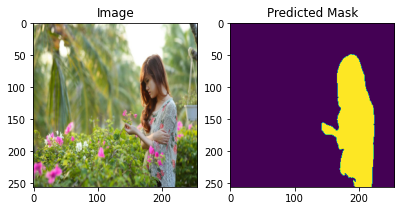

1/1 [==============================] - 0s 25ms/step


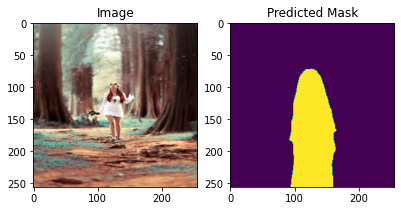

1/1 [==============================] - 0s 25ms/step


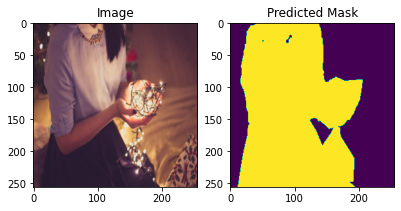

1/1 [==============================] - 0s 25ms/step


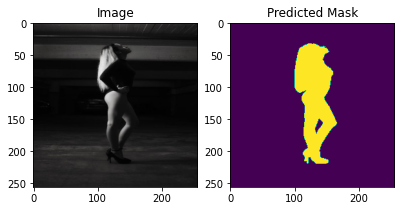

1/1 [==============================] - 0s 23ms/step


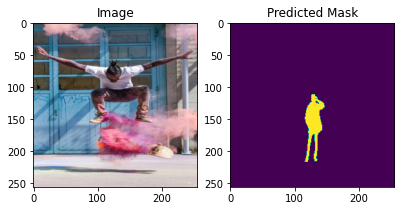

1/1 [==============================] - 0s 26ms/step


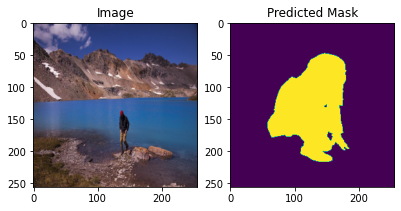

1/1 [==============================] - 0s 25ms/step


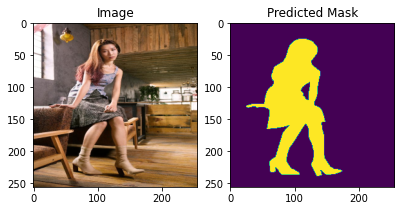

1/1 [==============================] - 0s 25ms/step


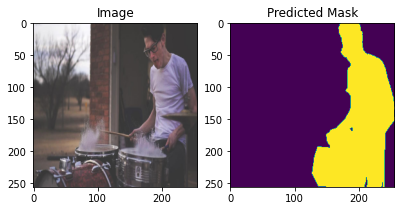

In [77]:
#https://github.com/harishhirthi/Indian-Traffic-Segmentation/blob/main/Segmentation.ipynb
# Visualizing the predicted mask for val data.
import random
ids = np.random.choice(images, size = 50, replace = False)
images =test_x[1:2000]
masks = test_y[1:2000]
images1= np.arange(len(images))
for i in range(len(ids)):
    image = cv2.imread(images[i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256, 256),  interpolation = cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image, axis=0)

    mask  = cv2.imread(masks[i], cv2.IMREAD_UNCHANGED)
    mask = cv2.resize(mask, (256, 256),  interpolation = cv2.INTER_AREA)
    mask = mask / 10
    pred = model2.predict(image,verbose=1)
    pred = tf.argmax(pred, axis=-1)

    fig = plt.figure(figsize=(10,6))
    #plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(131)
    ax1.imshow(image[0,:,:])
    ax2=fig.add_subplot(132)
    ax2.imshow(mask)
    #ax3=fig.add_subplot(133)
    #ax3.imshow(pred[0,:,:])
    ax1.title.set_text('Image')
    ax2.title.set_text('Predicted Mask')
    #ax3.title.set_text('Predicted Mask')
    plt.show()

In [78]:
 """ Load the test images """
test_images = []
for i in os.listdir(root_dir+'/test_images'):  
    test_images.append(root_dir+'/test_images/'+str(i))

In [106]:
 for path in tqdm(test_images, total=len(test_images)):
        x = cv2.imread(path, cv2.IMREAD_COLOR)
        original_image = x
        h, w, _ = x.shape

        x = cv2.resize(x, (256, 256))
        x = x/255.0
        x = x.astype(np.float32)

        x = np.expand_dims(x, axis=0)
        pred_mask = model2.predict(x)[0]

        pred_mask = np.concatenate(
            [
                pred_mask,
                pred_mask,
                pred_mask
            ], axis=2)
        pred_mask = (pred_mask > 0.5) * 255
        pred_mask = pred_mask.astype(np.float32)
        pred_mask = cv2.resize(pred_mask, (w, h))

        original_image = original_image.astype(np.float32)

        alpha = 0.6
        #cv2.addWeighted(pred_mask, alpha, original_image, 1-alpha, 0, original_image)

        name = path.split("/")[-1]
        cv2.imwrite(f"test_images/{name}", original_image)

100%|██████████| 7/7 [00:00<00:00,  9.07it/s]
